<a href="https://colab.research.google.com/github/marco-finger/derLauch/blob/main/CodingTask1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Science Fundamentals for DCBP, S. Haug, University of Bern 

# Coding Task 1

- Deadline (upload to Ilias): 2022-03-20 24:00
- Estimated effort: 2-5 hours
- Data on Ilias (4ms_...) with metadata file CCD-Metadata


## Tasks (maximum 12.5 points)

- Write a method (function) which removes the header information in the datafile and saves that information into a separate textfile. [0.5 points] 
- Write a function which reduces the data resolution by averaging over 1, 2, 3 and 4 nm wavelengths. Save these 4 new reduced datasets in new files. Do this (1) by writing an explicit loop and (2) by using pandas methods. Measure the running times of the two approaches. [6 points]
- Write a function which takes two wavelengths as input and plots the difference of the data at these lengths over time. [2 points] 
- Let the x-axis be in seconds, label the axes with names and units, label the plot with color and legend, make a title for the plot. Save the plot to a file. [2 points]
- Plot the full and the reduced datasets in the same figure. Is there any visual difference? [2 points]

In [48]:
# import of standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [88]:
# mount dataset from Google drive
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/DSF-FS22/data/task1/4ms_10 av_30 s_Absorbance_10-32-04-868.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# investigating dataframe
# df.info()
# df.describe()
# df.head()
# df.tail()

### 1. Removing header (0.5 points)

In [89]:
def remove_header(path): # function that removes the header
    header = []
    try:
        file = open(path, encoding = 'utf-8') # https://stackoverflow.com/a/12944855
        for line in iter(file.readline, b''): # iteration over header columns
            if line == ">>>>>Begin Spectral Data<<<<<\n": # start of the spectrum
                break
            header.append(line) # appends line by line of header
    finally:
        file.close()
    return header

In [90]:
header = remove_header("/content/drive/MyDrive/DSF-FS22/data/task1/4ms_10 av_30 s_Absorbance_10-32-04-868.txt")

In [91]:
def save_header(header, path): # function to save header information as a seperate file
    try:
        file = open(path, 'w', encoding = 'utf-8') # utf-8 encoded text file
        for line in header: # iteration over all header lines
            file.write(line)
    finally:
        file.close()

In [92]:
save_header(header, '/content/drive/MyDrive/DSF-FS22/data/task1/CCD-Header.csv') # saves the header information into file called "CCD-Header.csv"

In [93]:
def split_data(path, filename): # function that splits the original csv file into header and data
    lines = [] 

    # Split file into header and data
    try:
        file = open(path + filename, encoding = 'utf-8')
        # read and store all lines into list
        lines = file.readlines()
        file.close()
        # Open header file
        file = open(path + 'CCD-Header.csv', 'w', encoding = 'utf-8')
        for line in lines:
            if line == ">>>>>Begin Spectral Data<<<<<\n":
                # Switch to data file
                file.close()
                file = open(path + 'CCD-Data.csv', 'w', encoding = 'utf-8')
                continue
            file.write(line)
    finally:
        file.close()

In [94]:
split_data("/content/drive/MyDrive/DSF-FS22/data/task1/", "4ms_10 av_30 s_Absorbance_10-32-04-868.txt")

#### Old Approach

In [4]:
# df = pd.read_csv(path, delimiter='\t', header = 13) # header taken as from row 13 
# df = df.drop(columns = "Unnamed: 0") # removes the redundant first column
# df.to_csv('/content/drive/MyDrive/DSF-FS22/data/task1/CCD-Data.csv') # creates a csv file containg only the data and saves it into a folder called "task1"
# df = df.rename(columns={"Unnamed: 1": "time"}) # calling first column "time"

### 2. Reducing data resolution (6 points)


In [106]:
wavelengths = [] # save wavelengths as a list
try:
    f = open("/content/drive/MyDrive/DSF-FS22/data/task1/" + "CCD-Data.csv") # where to grap the data
    # remove the first two values and convert to float by applying a map function
    wavelengths = list(map(float, f.readline().split("\t")[2:])) # wavelengths start with index 2
finally:
    f.close()

In [98]:
wavelengths[0:10] # call the wavelengths saved as a list

[316.6137,
 316.7492,
 316.8847,
 317.0203,
 317.1558,
 317.2913,
 317.4268,
 317.5623,
 317.6977,
 317.8332]

In [108]:
def extract_indices(wavelengths, binning_value): # binning_value means data resolution
    indices = [0]
    for index, wavelength in enumerate(wavelengths): # interation through a list using the enumerate() method
        if (int(wavelength) - int(wavelengths[indices[-1]]) < binning_value): # float to int conversion; binning wavelength indices within "binning_value"
            continue
        indices.append(index)
    return indices

In [109]:
indices = extract_indices(wavelengths, 4)

In [101]:
zipped_indices = list(zip(indices, indices[1:])) # https://note.nkmk.me/en/python-for-enumerate-zip/ geting elements for lists

In [110]:
zipped_indices[:4]

[(0, 25), (25, 55), (55, 85), (85, 114)]

In [118]:
def aggregate_explicit(path, data_filename, indices):
    lines = []
    # Split file into header and data
    try:
        file = open(path + data_filename, encoding = 'utf-8')
        # read and store all lines but first into list
        lines = file.readlines()[1:]
        file.close()
        file = open(path + "CCD-Data_aggregated.txt", 'w', encoding = 'utf-8')
        for line in lines:
            # extract values
            values = line.split("\t")
            # write timestamps
            file.write("\t".join(values[:2]))
            # skip timestamp and convert values to float
            values = list(map(float, values[2:]))
            for (start, end) in indices:
                file.write("\t")
                # calculate mean
                value = sum(values[start:end]) / (end - start)
                file.write(str(value))
            file.write("\n")
    finally:
        file.close()

In [119]:
aggregate_explicit("/content/drive/MyDrive/DSF-FS22/data/task1/", "CCD-Data.csv", zipped_indices) 

In [129]:
# measuring run time of the loop approach
%%timeit -n 10000 -r 5      


def explicit_aggregate_wavelengths(path, data_filename, binning_value):
    try:
        file = open(path + data_filename)
        # remove the first two values and convert to float by applying a map function
        wavelengths = list(map(float, file.readline().split("\t")[2:]))
        indices = [0]
        for index, wavelength in enumerate(wavelengths):
            if (int(wavelength) - int(wavelengths[indices[-1]]) < binning_value):
                continue
            indices.append(index)
        zipped_indices = list(zip(indices, indices[1:]))
        lines = file.readlines()
        file.close()
        file = open(path + "CCD-Data_" + str(binning_value) + "nm.txt", 'w', encoding = 'utf-8')
        for line in lines:
            # extract values
            values = line.split("\t")
            # write timestamps
            file.write("\t".join(values[:2]))
            # skip timestamp and convert values to float
            values = list(map(float, values[2:]))
            for (start, end) in zipped_indices:
                file.write("\t")
                # calculate mean
                value = sum(values[start:end]) / (end - start)
                file.write(str(value))
            file.write("\n")
    finally:
        f.close()   

10000 loops, best of 5: 73.6 ns per loop


In [127]:
for i in [1,2,3,4]: # for binning with resolutions of 1-4 nm
    explicit_aggregate_wavelengths("/content/drive/MyDrive/DSF-FS22/data/task1/", "CCD-Data.csv", i)

ParserError: ignored

In [5]:
# rescaling the time column

time = df.iloc[:,0]

time_zero = time[0]

for i in range(len(time)):
  time[i] = time[i] - time_zero

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
df.head()

,time,316.6137,316.7492,316.8847,317.0203,317.1558,317.2913,317.4268,317.5623,317.6977,...,778.9703,779.089,779.2076,779.3263,779.4449,779.5636,779.6822,779.8008,779.9194,780.0381
0,0,0.329672,0.329672,0.329672,0.090294,-0.716926,-1.829304,-0.686330,-0.428776,1.740363,...,-0.038483,-0.039623,-0.036920,-0.037309,-0.037299,-0.037476,-0.036856,-0.036853,-0.039100,-0.035545
1,89,-0.044412,-0.044412,-0.044412,0.157632,-0.672423,-2.183981,-0.492421,-0.000000,-0.695800,...,-0.039428,-0.038486,-0.037309,-0.036357,-0.037289,-0.038728,-0.037214,-0.036902,-0.040210,-0.038165
2,173,0.338219,0.338219,0.338219,0.330993,-0.879836,-0.000000,-0.559845,-0.000000,-0.275276,...,-0.037725,-0.037534,-0.036560,-0.036152,-0.036554,-0.036875,-0.037351,-0.036746,-0.038686,-0.036903
3,257,-0.049682,-0.049682,-0.049682,0.519086,-0.681150,-0.000000,-0.417230,-0.000000,-0.140451,...,-0.037613,-0.037168,-0.036369,-0.034549,-0.036252,-0.037948,-0.036713,-0.035706,-0.038203,-0.036822
4,340,0.335086,0.335086,0.335086,-0.041393,-0.000000,-1.802774,-0.510417,-0.000000,-0.000000,...,-0.040919,-0.038288,-0.035840,-0.035638,-0.039504,-0.040093,-0.039953,-0.037656,-0.038082,-0.035900


In [28]:
def split_data(path, filename): # function that splits the original csv file into header and data
    lines = [] # empty list

    # Split file into header and data
    try:
        file = open(path + filename, encoding = 'utf-8')
        # read and store all lines into list
        lines = file.readlines()
        file.close()
        # Open header file
        file = open(path + 'CCD-Header.csv', 'w', encoding = 'utf-8')
        for line in lines:
            if line == ">>>>>Begin Spectral Data<<<<<\n":
                # Switch to data file
                file.close()
                file = open(path + 'CCD-Data.csv', 'w', encoding = 'utf-8')
                continue
            file.write(line)
    finally:
        file.close()

In [31]:
split_data("/content/drive/MyDrive/DSF-FS22/data", "4ms_10 av_30 s_Absorbance_10-32-04-868.txt")

UnboundLocalError: ignored

### 3. Wavelength difference (2 points)

Text(0, 0.5, 'Difference in Intensity / a.u')

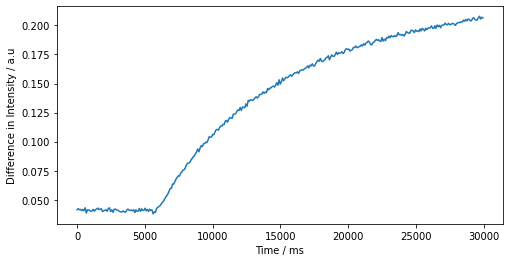

In [13]:
y = -(df.iloc[:,1950]-df.iloc[:,1800]) # takes two wavelengths

plt.figure(figsize = (8,4)) # modify picture size
plt.plot(time,y) # plot of the difference in intensity at two wavelengths over time
plt.xlabel('Time / ms') # x-label
plt.ylabel('Difference in Intensity / a.u') # y-label

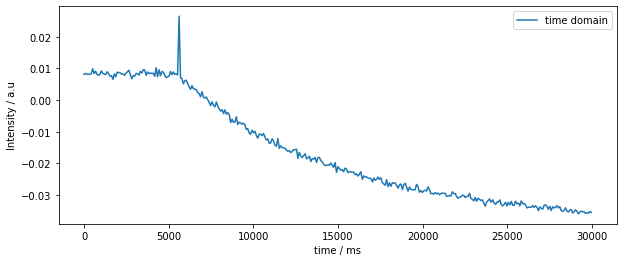

In [ ]:
plt.figure(figsize = (10,4))


plt.plot(time, df.iloc[:,1950], label = "time domain") 
plt.xlabel('time / ms')
plt.ylabel('Intensity / a.u')
plt.legend()


(3647,)


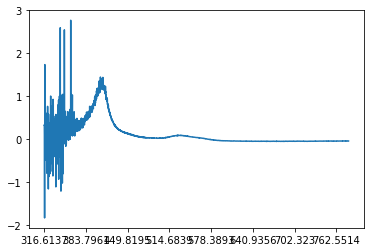

In [ ]:
df1 = df.iloc[0,1:-1]
print(df1.shape)
df1.plot()

In [ ]:
type(df1)

pandas.core.series.Series

In [ ]:
type(time)

pandas.core.series.Series

In [ ]:
# df[0].apply(lambda x: x-df.iloc[[0],[1]])